In [1]:
import numpy as np
import os
import rasterio
from rasterio.plot import show
import rasterio as rio
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from skimage.segmentation import quickshift
import skimage.data as data
import skimage.segmentation as seg
from skimage import filters
from skimage import draw
from skimage import color
from skimage import exposure
#
from ipywidgets import interact
from ipywidgets import widgets
from datetime import datetime
import plotly.graph_objects as go
#own function
from functions_current import *
import random
from ipywidgets import (
    VBox, HBox, Dropdown, IntSlider, FloatSlider, Checkbox, Text, Button, Output
)
from IPython.display import display, clear_output
from collections import deque

# Interactive labelling

For now it uses one plot at a time, at somne point also looking at images should be added. 


Currently, it uses the down sampled data, but object based data should be usable for it. 

#### Interactive Plot Function

In [2]:
def interactive_plot(data, csv_path=None, indexes=None):
    '''
        Launches an interactive plot that shows a time-series for a pixel.
    
    Features:
      - The pixel index is chosen at random by default.
      - A checkbox allows the user to enable manual control of the index.
      - Users can adjust various parameters and then confirm a label,
        which is saved in a global DataFrame.
      - Upon confirmation, if manual mode is off, a new random pixel is selected.
      - If a CSV file path is provided, the function will load existing labels
        from that file and save any changes back to it.
    
    Parameters:
      - data: A pandas DataFrame containing pixel time-series data. It should contain at least:
          - 'x', 'y': Pixel coordinates
          - 'time': Time information
          - 'clear': Quality indicator
          - Additional columns corresponding to different spectral bands.
      - csv_path: (Optional) A file path to a CSV file to load/save the labels.
      - indexes: (Optional) A file input containing a column named original_index, 
      allowing the review of specific pixels instead of selecting them randomly.
    '''
    
    global label_df

    # Load existing labels if available, otherwise create a new DataFrame.
    if csv_path is not None and os.path.exists(csv_path):
        label_df = pd.read_csv(csv_path)
        print(f"Loaded existing labels from {csv_path}.")
    else:
        label_df = pd.DataFrame(columns=[
            'x', 'y', 'User', 'status', 'explanation',
            'timestamp', 'vert_line_x', 'second_vert_line_x', 'original_index'
        ])

    # Define band options and their corresponding colors.
    band_options = {
        'RGB + NIR': ['blue', 'green', 'red', 'infrared'],
        'RGB + Red Edge + NIR': ['blue', 'green', 'red', 'red_edge', 'infrared'],
        'All Bands': ['coastal_blue', 'blue', 'turquoise', 'green', 'yellow', 'red', 'red_edge', 'infrared'],
        'Coastal Blue': ['coastal_blue'],
        'Blue': ['blue'],
        'Turquoise': ['turquoise'],
        'Green': ['green'],
        'Yellow': ['yellow'],
        'Red': ['red'],
        'Red Edge': ['red_edge'],
        'Infrared': ['infrared']
    }
    color_options = {
        'RGB + NIR': ['blue', 'lime', 'red', 'gray'],
        'RGB + Red Edge + NIR': ['blue', 'lime', 'red', 'magenta', 'gray'],
        'All Bands': ['navy', 'blue', 'turquoise', 'green', 'yellow', 'red', 'magenta', 'gray'],
        'Coastal Blue': ['navy'],
        'Blue': ['blue'],
        'Turquoise': ['turquoise'],
        'Green': ['green'],
        'Yellow': ['yellow'],
        'Red': ['red'],
        'Red Edge': ['magenta'],
        'Infrared': ['gray']
    }

    # Determine whether to use a provided list of indexes.
    if indexes is not None and 'original_index' in indexes.columns and not indexes.empty:
        provided_indexes = indexes['original_index'].tolist()
        index_queue = deque(provided_indexes)
        use_only_provided_indexes = True
    else:
        provided_indexes = list(range(len(data)))
        index_queue = None
        use_only_provided_indexes = False

    def get_next_index():
        if use_only_provided_indexes:
            # Loop through the provided indexes until a valid candidate is found.
            while index_queue:
                candidate = index_queue.popleft()
                if 0 <= candidate < len(data):
                    return candidate
                else:
                    print(f"Index {candidate} is out-of-bounds for data of length {len(data)}, skipping.")
            print("All labeled pixels have been reviewed. No more indexes to process.")
            return None
        return random.randint(0, len(data) - 1)

    first_index = get_next_index()
    if first_index is None:
        print("No indexes available to process. Exiting...")
        return

    # Create an index slider. If using provided indexes, restrict the slider range.
    if use_only_provided_indexes:
        min_index = min(provided_indexes)
        max_index = max(provided_indexes)
        max_index = min(max_index, len(data) - 1)  # cap at data bounds
        rand_index = IntSlider(value=first_index, min=min_index, max=max_index, step=1, description='Index:', disabled=True)
    else:
        rand_index = IntSlider(value=first_index, min=0, max=len(data)-1, step=1, description='Index:', disabled=True)
    
    manual_index_widget = Checkbox(value=False, description="Manually select index")
    def toggle_index_control(change):
        rand_index.disabled = not change['new']
    manual_index_widget.observe(toggle_index_control, names='value')

    # Create the Output widget for plotting.
    out = Output()

    # Create additional parameter widgets.
    bands_widget = Dropdown(options=list(band_options.keys()), description='Bands:')
    lim_widget = FloatSlider(value=0.5, min=0, max=1, step=0.05, description='Quality Lim:')
    start_dat_widget = IntSlider(value=0, min=0, max=100, step=1, description='Start:')
    deltmag_widget = FloatSlider(value=1, min=0.5, max=5, step=0.1, description='Space Between Bands:')
    quant_widget = FloatSlider(value=0.01, min=0, max=0.1, step=0.01, description='Quantile:')
    vert_line_x_widget = FloatSlider(value=data['time'].min(), min=data['time'].min(), max=data['time'].max(), step=0.01, description='Line 1 (time):')
    second_vert_line_x_widget = FloatSlider(value=data['time'].min(), min=data['time'].min(), max=data['time'].max(), step=0.01, description='Line 2 (time):')
    show_vert_line_widget = Checkbox(value=False, description="Show First Line")
    show_second_line_widget = Checkbox(value=False, description="Show Second Line")
    user_widget = Dropdown(options=['None', 'Zach', 'Tobias', 'Devon', 'Kiana', 'Jonathan'], description='User:')
    label_widget = Dropdown(options=['Not_classified_yet','Anomalous','Not_anomalous','Uncertain'], description='Label:')
    explanation_widget = Text(value='', description='Explanation:')
    confirm_button = Button(description="Confirm Label", button_style='success')
    point_size_widget = FloatSlider(value=2, min=1, max=10, step=0.5, description='Point Size:') # new

    def plot_and_label(bands, index, lim, start_dat, deltmag, quant, vert_line_x,
                       show_first_line, second_vert_line_x, show_second_line,
                       user, label, explanation,point_size, confirm=False):
        try:
            # Retrieve the pixel data by positional index.
            pixel_data = data.iloc[index]
        except IndexError:
            print(f"IndexError: The provided index {index} is out-of-bounds for data with length {len(data)}.")
            return

        x, y = pixel_data['x'], pixel_data['y']
        # Filter the data for this pixel (using its coordinates).
        pixel_data = data[(data['x'] == x) & (data['y'] == y)]
        if pixel_data.empty:
            print("No data available for the selected coordinates.")
            return

        quality = pixel_data['clear']
        dates = pixel_data['time']
        selected_bands = band_options[bands]
        colors = color_options[bands]
        values = pixel_data[selected_bands]

        plt.figure(figsize=(10, 6))
        # Plot each band with an offset.
        for i, color in enumerate(colors):
            valid = quality > lim
            dates_sel = dates[valid].iloc[start_dat:]
            data_sel = values[valid].iloc[start_dat:, i]
            lims = np.quantile(data_sel, [quant, 1 - quant])
            plt.plot(dates_sel, (data_sel - lims[0]) / (lims[1] - lims[0]) + i * deltmag,
                     'o', ms=point_size, color=color)

        if show_first_line and vert_line_x is not None:
            plt.axvline(x=vert_line_x, color='black', linestyle='--', label=f"Line 1 (x={vert_line_x:.2f})")
        if show_second_line and second_vert_line_x is not None:
            plt.axvline(x=second_vert_line_x, color='red', linestyle='--', label=f"Line 2 (x={second_vert_line_x:.2f})")

        plt.title(f"Plot for pixel ({x}, {y}) and bands: {bands}")
        plt.xlabel('Time')
        plt.ylim(-0.02, 1 + (len(colors) - 1) * deltmag + 0.02)
        plt.grid()
        handles, lab = plt.gca().get_legend_handles_labels()
        if lab:
            plt.legend()
        plt.show()

        if confirm:
            global label_df
            # If lines are not shown, set their values to None.
            if not show_first_line:
                vert_line_x = None
            if not show_second_line:
                second_vert_line_x = None
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            # Check for an existing label for this pixel.
            existing_index = label_df[(label_df['x'] == x) & (label_df['y'] == y)].index
            if not existing_index.empty:
                label_df.loc[existing_index, :] = [[x, y, user, label, explanation,
                                                     timestamp, vert_line_x, second_vert_line_x, index]]
                print(f"Label for pixel ({x}, {y}) updated.")
            else:
                new_row = {
                    'x': x,
                    'y': y,
                    'User': user,
                    'status': label,
                    'explanation': explanation,
                    'timestamp': timestamp,
                    'vert_line_x': vert_line_x,
                    'second_vert_line_x': second_vert_line_x,
                    'original_index': index
                }
                label_df = pd.concat([label_df, pd.DataFrame([new_row])], ignore_index=True)
                print(f"Label for pixel ({x}, {y}) added.")
            #print(label_df)
            if csv_path is not None:
                label_df.to_csv(csv_path, index=False)
                print(f"Labels saved to {csv_path}")

    def update_plot(*args):
        with out:
            clear_output(wait=True)
            if rand_index.value < 0 or rand_index.value >= len(data):
                print(f"Index {rand_index.value} is out-of-bounds.")
                return
            plot_and_label(
                bands=bands_widget.value,
                index=rand_index.value,
                lim=lim_widget.value,
                start_dat=start_dat_widget.value,
                deltmag=deltmag_widget.value,
                quant=quant_widget.value,
                vert_line_x=vert_line_x_widget.value,
                show_first_line=show_vert_line_widget.value,
                second_vert_line_x=second_vert_line_x_widget.value,
                show_second_line=show_second_line_widget.value,
                user=user_widget.value,
                label=label_widget.value,
                explanation=explanation_widget.value,
                point_size=point_size_widget.value,  # Pass the point size h
                confirm=False
            )

    # Attach observers so that changes in any widget update the plot.
    for widget in [bands_widget, lim_widget, start_dat_widget, deltmag_widget, quant_widget,
                   vert_line_x_widget, show_vert_line_widget, second_vert_line_x_widget, show_second_line_widget,
                   user_widget, label_widget, point_size_widget]:
        widget.observe(lambda change: update_plot(), names='value')

    update_plot()

    def on_confirm_clicked(b):
        with out:
            clear_output(wait=True)
            plot_and_label(
                bands=bands_widget.value,
                index=rand_index.value,
                lim=lim_widget.value,
                start_dat=start_dat_widget.value,
                deltmag=deltmag_widget.value,
                quant=quant_widget.value,
                vert_line_x=vert_line_x_widget.value,
                show_first_line=show_vert_line_widget.value,
                second_vert_line_x=second_vert_line_x_widget.value,
                show_second_line=show_second_line_widget.value,
                user=user_widget.value,
                label=label_widget.value,
                explanation=explanation_widget.value,
                point_size=point_size_widget.value,
                confirm=True
            )
        label_widget.value = "Not_classified_yet"
        if not manual_index_widget.value:
            next_index = get_next_index()
            if next_index is not None:
                rand_index.value = next_index
            else:
                rand_index.disabled = True
        update_plot()

    confirm_button.on_click(on_confirm_clicked)

    # Layout the widgets.
    ui_left = VBox([bands_widget, HBox([rand_index, manual_index_widget]), lim_widget, start_dat_widget, deltmag_widget, quant_widget,  point_size_widget])
    ui_mid = VBox([vert_line_x_widget, show_vert_line_widget, second_vert_line_x_widget, show_second_line_widget])
    ui_right = VBox([user_widget, label_widget, explanation_widget, confirm_button])
    ui = HBox([ui_left, ui_mid, ui_right])
    
    display(ui, out)

In [3]:
# Function to save label_df (from above function) to a CSV file to be saved for later #

def save_labels_to_csv(csv_path="labels.csv"):
    '''
    Save Labeled Dataframe as a CSV
    
    Can name CSV file through function input: csv_path = "CSV FILE NAME"
    '''
    global label_df
    try:
        label_df.to_csv(csv_path, index=False)
        print(f"Labels saved to {csv_path}")
    except Exception as e:
        print("Error saving CSV:", e)

How the saving works:
- right now if there is no input CSV file to the*interact_plot_with_labels* function, it will create a dataframe locally, so to save it to CSV file once done labelling, use the *save_labels_to_csv* function to save the label_df as a CSV (can choose name as input of the function, will save to working directory)
- if a CSV file already exists, then use the path or name of the file as input to the *interact_plot_with_labels* function (second input is where you specify CSV if applicable), everytime you label a pixel, the CSV will automatically update

In [4]:
#the (downsampled) data file to be changed between location
#dat=pd.read_csv('../limpopo_v1.csv.gz')
dat=pd.read_csv('../kakamega_v1.csv.gz')

In [7]:
#the indecxes to be chcked, name will still change
indexes=pd.read_csv('../kakamega_extremes_v1.csv')

In [8]:
# Can run new function here which has additional (optional) input for existing csv file/labeled dataframe
#(mean) x and y can be displayed
#running it, here the path to the file where it should be saved is given 
interactive_plot(dat,csv_path='tobias_kakamega_ind1.csv',indexes=indexes)

Output()

All labeled pixels have been reviewed. No more indexes to process.


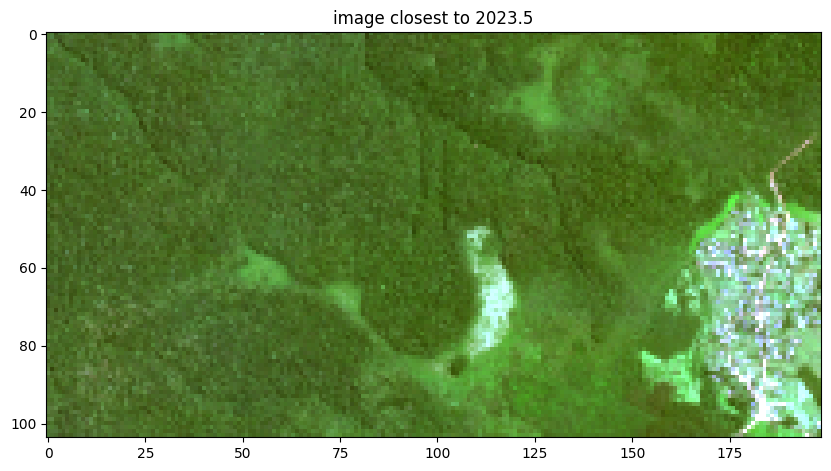

In [6]:
display_image_back(dat,time_axis_direct=False,time_el=-1,exclude=0.4,examples=[],time_date=2023.5)

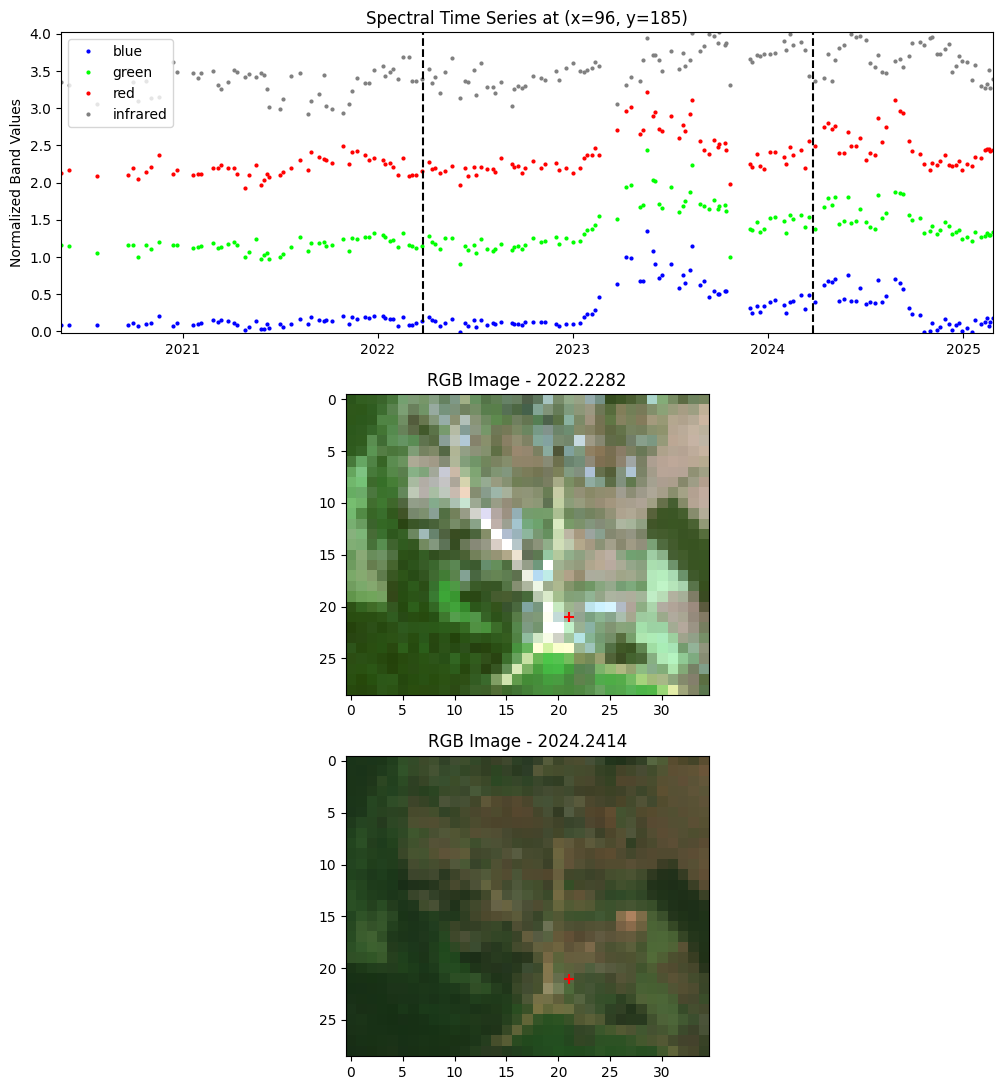

In [116]:

plot_time_space_delt(dat,0,xy=[96,185],el_given=False,lines=[2022.23,2024.23],exclude=0.02,deltpos=1,delt_display=21,quant=0.02)

In generel less anomalies in Kakamega, revist the one swhich ahev only at the very end. Semms just an extra dry period and more data.  Also curvature in the center is not sure, maybe also just climate. 

In [ ]:
meds=dat[(dat.y<150) ].groupby('time').median()


time
2020.377878      8.230000
2020.416134     16.370001
2020.560941    156.360001
2020.719510     91.035000
2020.746741    295.024994
                  ...    
2025.110543     22.860001
2025.121498     33.400002
2025.132460      1.000000
2025.140675     78.564999
2025.154378     49.450001
Name: blue, Length: 174, dtype: float64


(0.0, 4000.0)

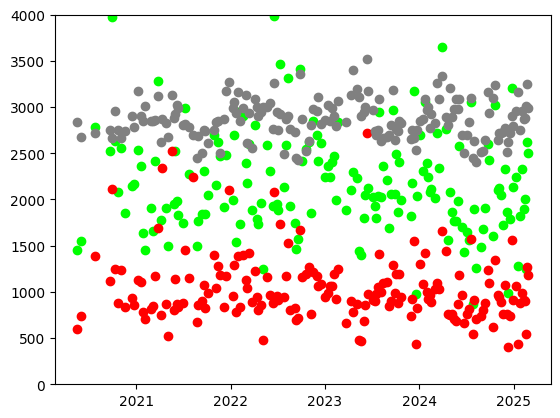

In [33]:
print(meds.blue)

#plt.plot(meds.index,meds.blue*30,'o',color='blue')
plt.plot(meds.index,meds.green*8,'o',color='lime')
plt.plot(meds.index,meds.red*5,'o',color='red')
plt.plot(meds.index,meds.infrared,'o',color='gray')
plt.ylim(0,4000)

Median has that curvature. 

In [19]:
meds2=dat[(dat.y>160) & (dat.x>40)].groupby('time').median()
print(meds2)

             Unnamed: 0  coastal_blue        blue   turquoise       green  \
time                                                                        
2020.377878   2524305.0      4.195000   65.255001  338.885010  416.710007   
2020.416134   2524306.0      4.530000   60.910000  334.315002  402.175003   
2020.560941   2524307.0     83.535000  232.230003  447.039993  513.489990   
2020.719510   2524308.0     80.310001  198.660004  480.344986  583.304993   
2020.746741   2524309.0    306.520004  435.405014  666.144989  745.389984   
...                 ...           ...         ...         ...         ...   
2025.110543   2524474.0     17.640000  133.555000  443.770004  480.994995   
2025.121498   2524475.0     59.700001  170.639999  421.830002  514.985016   
2025.132460   2524476.0      1.000000   54.859999  301.824997  444.290009   
2025.140675   2524477.0    124.264999  285.509995  498.800003  638.834991   
2025.154378   2524478.0     75.309998  220.474998  446.150009  624.095001   

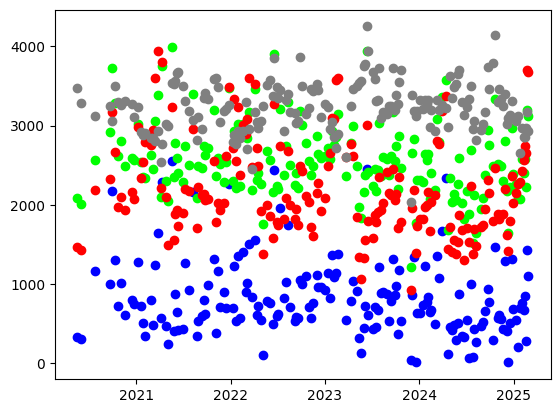

In [57]:
plt.plot(meds2.index,meds2.blue*5,'o',color='blue')
plt.plot(meds2.index,meds2.green*5,'o',color='lime')
plt.plot(meds2.index,meds2.red*5,'o',color='red')
plt.plot(meds2.index,meds2.infrared,'o',color='gray')
#plt.ylim(0,4000)

Clearer in the red of the area

In [52]:
a=pd.read_csv('../tobias_kakamega_labels_v1.csv')

In [53]:
print(a[(a.status!='Not_anomalous')])

Empty DataFrame
Columns: [x, y, User, status, explanation, timestamp, vert_line_x, second_vert_line_x, original_index]
Index: []


In [118]:
b=pd.read_csv('tobias_kakamega_ind1.csv')

In [119]:
print(b[(b.status!='Not_anomalous')])

       x      y  User     status              explanation  \
0   97.0  183.0  None  Anomalous                      NaN   
2   91.0  183.0  None  Anomalous                    clear   
5   57.0  171.0  None  Anomalous                   breaks   
8   60.0  179.0  None  Anomalous     more variations then   
9   95.0  188.0  None  Anomalous           blue curvature   
13  53.0  179.0  None  Anomalous                    break   
14  73.0  182.0  None  Anomalous                    trend   
16  87.0  177.0  None  Anomalous             breaks clear   
18  88.0  178.0  None  Anomalous             clear breaks   
22  88.0  184.0  None  Anomalous  breaks clearer in delta   
28  89.0  179.0  None  Anomalous           break in delta   
29  96.0  185.0  None  Anomalous           break in delta   

              timestamp  vert_line_x  second_vert_line_x  original_index  
0   2025-03-14 11:05:37  2021.400000                 NaN         3390564  
2   2025-03-14 11:06:42  2022.337878                 NaN